In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NGULIM.TTF'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font)

from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. 데이터 생성 (2차원 상관된 데이터)
np.random.seed(42)
n_samples = 100

# X1은 정규분포, X2는 X1과 상관된 값
X1 = np.random.normal(0, 1, n_samples)
X2 = 0.75 * X1 + np.random.normal(0, 0.25, n_samples)

X = np.vstack((X1, X2)).T  # 입력값의 shape = (100, 2)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 공분산 행렬 기반 PCA
cov_matrix = np.cov(X_scaled.T)
# eig : 일반 행렬들에 적용되는 고유값/고유벡터 계산 방식 (느림)
# eigh : 대칭 행렬에만 적용되는 고유값/고유벡터 계산 방식 (빠름)
# 여기선 cov_matrix(공분산 행렬)이 대칭행렬인걸 알기 때문에 eigh를 사용할 수 있다.
eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

# 고유값 내림차순 정렬
sorted_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sorted_idx]
eig_vecs = eig_vecs[:, sorted_idx]

# 3. SVD 기반 PCA
U, S, Vt = np.linalg.svd(X_scaled, full_matrices=False)

# 4. 비교 정리
comparison = pd.DataFrame({
    '공분산 기반 고유값': eig_vals,
    'SVD 기반 특이값^2 / n': (S ** 2) / n_samples,  # 분산 = 특이값 제곱 / 샘플 수
    '공분산 기반 1번째 주성분': eig_vecs[:, 0],
    'SVD 기반 1번째 주성분': Vt[0]
})

comparison

[0.06097149 1.95923053] [[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[1.95923053 0.06097149] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


,공분산 기반 고유값,SVD 기반 특이값^2 / n,공분산 기반 1번째 주성분,SVD 기반 1번째 주성분
0,1.959231,1.939638,0.707107,-0.707107
1,0.060971,0.060362,0.707107,-0.707107


둘이 거의 유사한 결과를 내놓는다는 것을 알 수 있음!

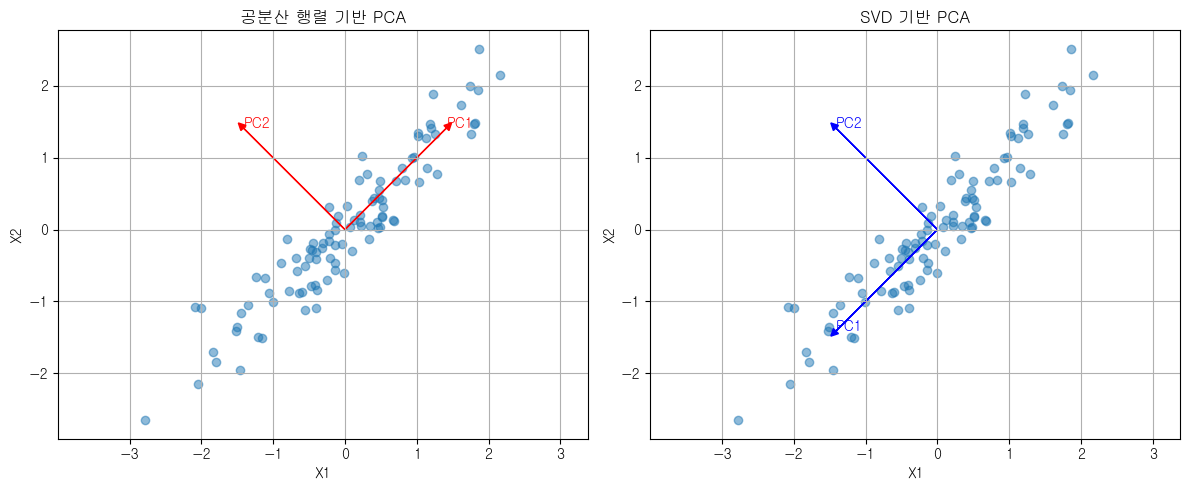

In [13]:
# 시각화: 공분산 기반 PCA vs SVD 기반 PCA를 나란히 비교

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

origin = np.mean(X_scaled, axis=0)

# 공분산 기반 PCA
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5, label="Original Data")
pca_vectors_cov = eig_vecs.T

for i in range(2):
    vec = pca_vectors_cov[i] * 2
    axes[0].arrow(origin[0], origin[1], vec[0], vec[1],
                  head_width=0.1, head_length=0.1, fc='red', ec='red')
    axes[0].text(origin[0] + vec[0], origin[1] + vec[1], f"PC{i+1}", color='red')

axes[0].set_title("공분산 행렬 기반 PCA")
axes[0].set_xlabel("X1")
axes[0].set_ylabel("X2")
axes[0].grid(True)
axes[0].axis('equal')

# SVD 기반 PCA
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5, label="Original Data")
pca_vectors_svd = Vt

for i in range(2):
    vec = pca_vectors_svd[i] * 2
    axes[1].arrow(origin[0], origin[1], vec[0], vec[1],
                  head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    axes[1].text(origin[0] + vec[0], origin[1] + vec[1], f"PC{i+1}", color='blue')

axes[1].set_title("SVD 기반 PCA")
axes[1].set_xlabel("X1")
axes[1].set_ylabel("X2")
axes[1].grid(True)
axes[1].axis('equal')

plt.tight_layout()
plt.show()


PC1의 방향이 서로 다르지만 중요한 것은 "해당 축을 따라 데이터가 얼마나 퍼져있는지?" 이기 때문에 정사영 결과는 서로 동일.

방향이 다르게 나온 이유는, SVD는 특이벡터의 부호가 언제든 바뀔 수 있기 때문. ((-1, -1)이나 (1, 1)이나 둘 다 해가 됨.)

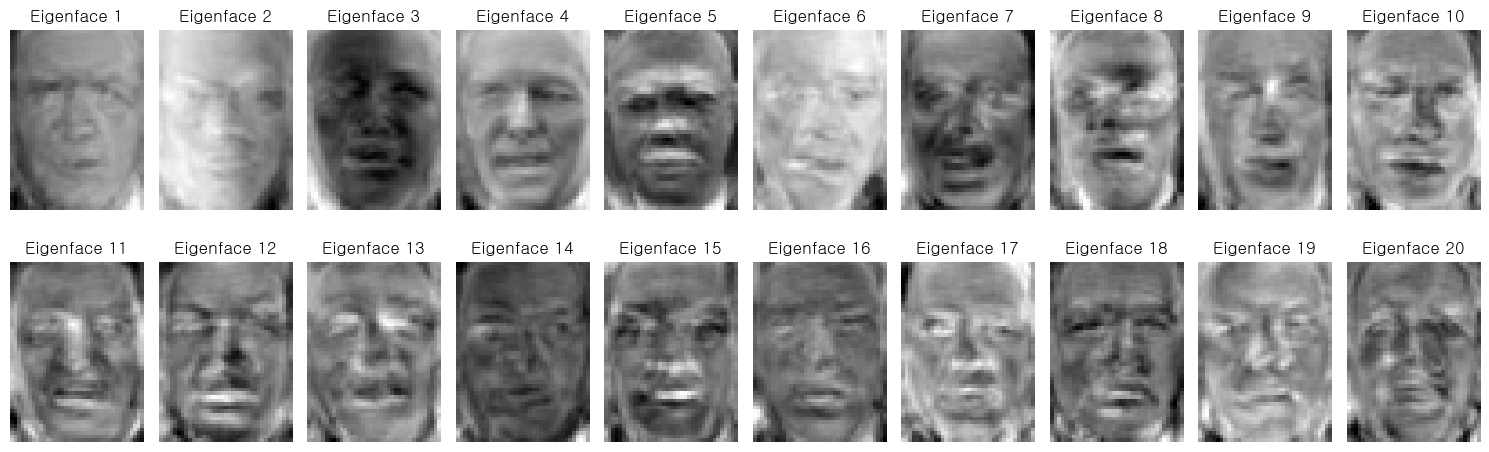

In [57]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 얼굴 이미지 데이터셋 불러오기 (20장만 사용)
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data[:50]
images = lfw_people.images[:50]
h, w = images[0].shape  # 이미지 높이, 너비

# PCA 수행 (eigenface)
n_components = 20

# PCA 수행
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

# 시각화: Eigenfaces
cols = n_components//2
fig, axes = plt.subplots(2, cols, figsize=(15, 5))
for i in range(n_components):
    axes[i//cols][i%cols].imshow(eigenfaces[i], cmap='gray')
    axes[i//cols][i%cols].set_title(f"Eigenface {i+1}")
    axes[i//cols][i%cols].axis('off')

plt.tight_layout()
plt.show()